# Decision Tree Regression

First we import all of our data and create the dropped column. We also add the columns `binPosemo` and `binNegemo` to create binary variables for positive and negative emotion.

In [109]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

DATA="/Users/aguang/CORE/tippingpoint/tippingpoint/data"
df_dv = pd.read_csv(os.path.join(DATA,"df_dv.dat"))
df_gc = pd.read_csv(os.path.join(DATA,"df_gc.dat"))
df_subject = pd.read_csv(os.path.join(DATA,"df_subject.dat"))
full_df = pd.read_csv(os.path.join(DATA,"full_df.dat"))
dropped = full_df.drop(columns=["impChange","impRise","impFall","impPeriodic","liwcCause","liwcFocusPre","liwcFocusFut","liwcRelativ","liwcTime"]).dropna()

In [94]:
def binary(col):
    return([1 if i > 0 else 0 for i in col])
        
liwcPosemo = dropped.loc[:,"liwcPosemo"]
binPosemo = binary(liwcPosemo)

liwcNegemo = dropped.loc[:,"liwcNegemo"]
binNegemo = binary(liwcNegemo)

In [95]:
dropped["binPosemo"] = binPosemo
dropped["binNegemo"] = binNegemo

Full decision tree. Interpreting the tree:
 * Variable in question. Go left if true and right if false.
 * Gini is gini impurity of node. If gini is close to 0 then there is essentially no uncertainty left. Otherwise there are still some potential splits to be made.
 * Sample is number of samples for that node
 * Value is count of samples in each class that have reached that node. First class is yes TP, and second class is No TP. This is not the same as their split within the variable in question.
 * Class is the class with the larger number of responses, either TP or No TP. 

In [162]:
from sklearn import tree
#feature_cols = ["risingBefore", "cannotSeeAfter", "downOverall", "bellOverall", "complexOverall", "expExec", "liwcPosemo", "liwcNegemo"]
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(dropped.iloc[:,5:],dropped.tp)

In [33]:
#making a plot
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

def decision_tree_image(decision_tree, features, file=None):
    dot_data = StringIO()
    tree.export_graphviz(decision_tree,out_file=dot_data,feature_names=features,
                         class_names=["TP","No TP"], filled=True, rounded=True,
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    if file:
        graph.write_png(file)
    img = Image(graph.create_png())
    return(img)

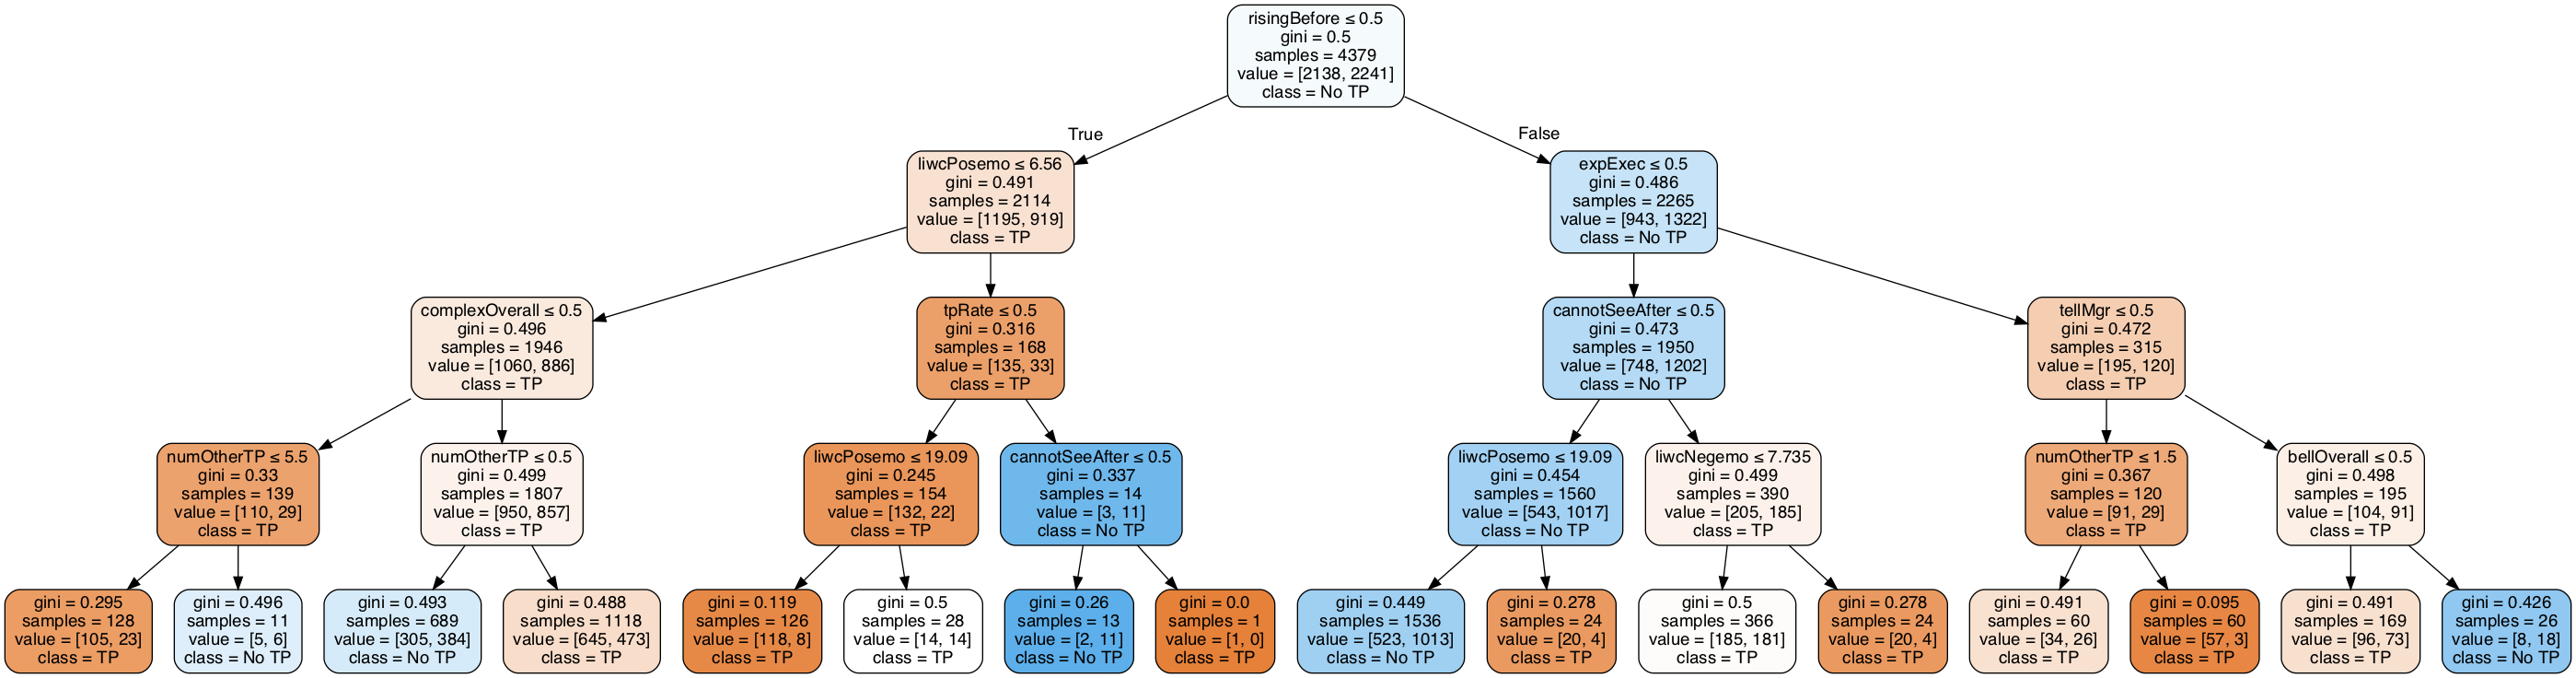

In [163]:
decision_tree_image(clf, dropped.columns[5:], "Figures/decision_tree_all.png")

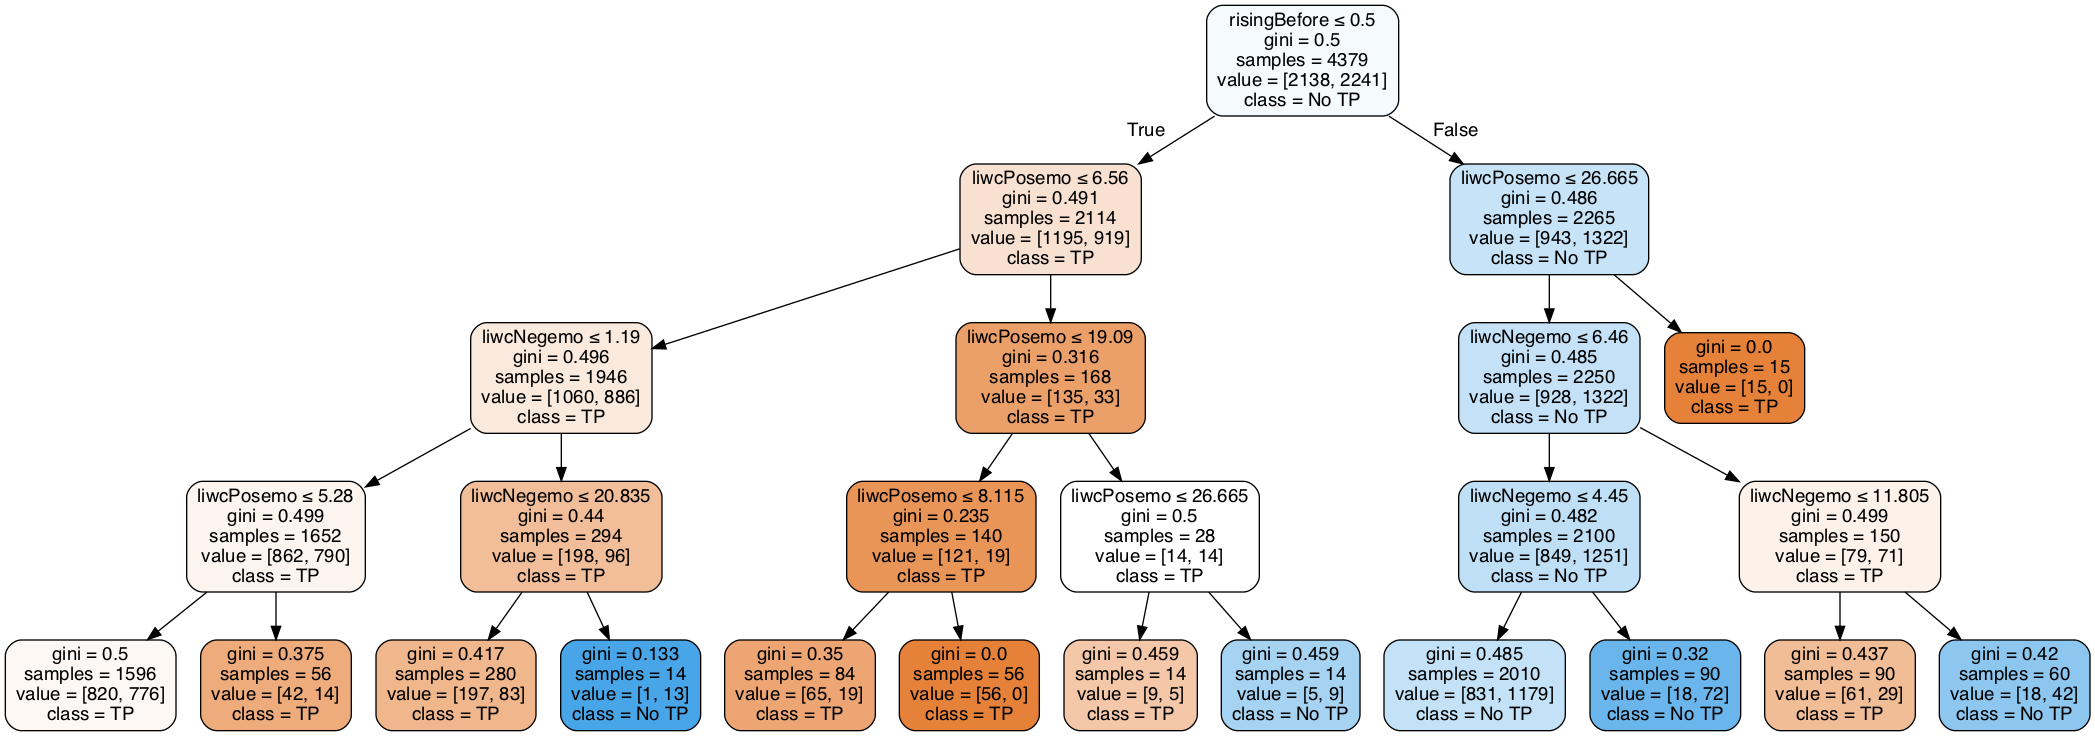

In [34]:
feature_cols2 = ["risingBefore", "liwcPosemo", "liwcNegemo"]
clf2 = tree.DecisionTreeClassifier(max_depth=4)
clf2 = clf2.fit(dropped[feature_cols2],dropped.tp)
decision_tree_image(clf2,feature_cols2)

In [186]:
importances = clf.feature_importances_
colnames = dropped.iloc[:,5:].columns
df_feature_importance = pd.DataFrame({'feature': colnames,
                                      'importance': importances},
                                     index=colnames).sort_values('importance', ascending=False)
df_feature_importance

,feature,importance
risingBefore,risingBefore,0.229211
liwcPosemo,liwcPosemo,0.193405
expExec,expExec,0.142069
numOtherTP,numOtherTP,0.127062
cannotSeeAfter,cannotSeeAfter,0.099234
complexOverall,complexOverall,0.086058
tpRate,tpRate,0.050114
tellMgr,tellMgr,0.035536
liwcNegemo,liwcNegemo,0.022878
bellOverall,bellOverall,0.014433


In [196]:
def importance_plot(classifier, df, classtype="RandomForest", file=None):
    importances = classifier.feature_importances_
    if classtype=="DecisionTree":
        pass
    else:
        std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
        
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(df.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    if classtype=="DecisionTree":
        plt.bar(range(df.shape[1]), importances[indices],
               color="r", align="center")
    else:
        plt.bar(range(df.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
    plt.xticks(range(df.shape[1]), df.columns[indices],rotation=90)
    plt.xlim([-1, df.shape[1]])
    if file is not None:
        plt.savefig(file)
    plt.show()

Feature ranking:
1. feature 0 (0.229211)
2. feature 13 (0.193405)
3. feature 6 (0.142069)
4. feature 12 (0.127062)
5. feature 1 (0.099234)
6. feature 4 (0.086058)
7. feature 8 (0.050114)
8. feature 11 (0.035536)
9. feature 14 (0.022878)
10. feature 3 (0.014433)
11. feature 10 (0.000000)
12. feature 9 (0.000000)
13. feature 7 (0.000000)
14. feature 5 (0.000000)
15. feature 2 (0.000000)


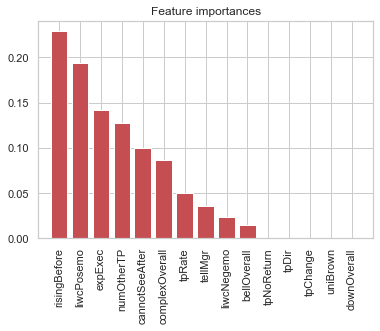

In [200]:
importance_plot(clf,dropped.iloc[:,5:],"DecisionTree","Figures/dt_importance.png")

## To do

 * ~~Decision tree but with variables and legend~~
 * ~~Feature importance plot of each feature on X axis and bar with order of importance~~
 * ~~Scatter plot of feature on X axis and feature on Y axis of 2 most important features~~
 * ~~Scale liweNegemo liwcPosemo for logistic regression~~
 * Logistic regression and mean/sd tables
     * How do you want these tables formatted, aka what format are you using to write the paper? Word table?
 * ~~Cross-validated decision tree by splitting on user ID~~

# Cross-validated random forest by splitting on user ID

This poses the question: given a new individual, can we predict how they will categorize a graph, and what features are important? The important features are quite different; however the accuracy is also not very good.

In [203]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier

def shuffle_split(groups,X=dropped.iloc[:,5:],y=dropped.iloc[:,2],
                  test_size=0.2,n_splits=2):
    np.random.seed(3851)
    train_inds, test_inds = next(GroupShuffleSplit(test_size,
                                                   n_splits).split(X,
                                                                  y,
                                                                  groups))
    return train_inds, test_inds

train_inds, test_inds = next(GroupShuffleSplit(test_size=0.2,
                                               n_splits=2).split(X=dropped.iloc[:,5:],y=dropped.iloc[:,2], groups=dropped['subj']))

X_train = dropped.iloc[train_inds,5:]
X_test = dropped.iloc[test_inds, 5:]
y_train = dropped.iloc[train_inds,2]
y_test = dropped.iloc[test_inds,2]

classifier = RandomForestClassifier(n_estimators=100)
classifier = classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [104]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", cm)

# Accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy score: ", acc)

y_test.value_counts()/len(y_test)

Confusion matrix:  [[257 221]
 [171 250]]
Accuracy score:  0.5639599555061179


0.0    0.531702
1.0    0.468298
Name: tp, dtype: float64

Feature ranking:
1. feature 12 (0.277967)
2. feature 14 (0.103108)
3. feature 13 (0.093121)
4. feature 0 (0.071828)
5. feature 9 (0.061056)
6. feature 10 (0.056489)
7. feature 1 (0.053252)
8. feature 8 (0.049152)
9. feature 11 (0.047479)
10. feature 5 (0.034764)
11. feature 4 (0.034502)
12. feature 2 (0.033276)
13. feature 6 (0.031196)
14. feature 3 (0.026815)
15. feature 7 (0.025996)


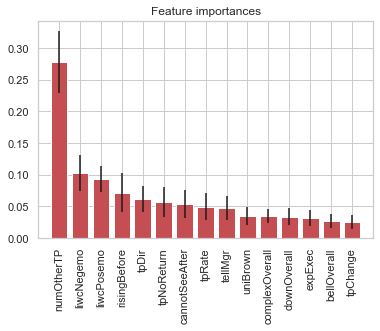

In [205]:
importance_plot(classifier, X_test, file="Figures/rf_subj.png")

In [206]:
acc_cross = cross_val_score(estimator = classifier,
                            X = X_train,
                            y=y_train, cv = 10)
print("Accuracies for 10 folds: ", acc_cross)
print("mean: ", acc_cross.mean())
print("sd: ", acc_cross.std())

Accuracies for 10 folds:  [0.45114943 0.58333333 0.66091954 0.6408046  0.5316092  0.46551724
 0.5545977  0.68678161 0.45977011 0.58333333]
mean:  0.5617816091954023
sd:  0.08093302934199806


# Cross-validated random forest by splitting on graphid

This asks the question, given a new graph, can we predict what it will be marked as, and what features are predictive? This remains similar to splitting on subject, but is much more accurate.

Confusion matrix:  [[392  62]
 [159 293]]
Accuracy score:  0.7560706401766004
proportion:  0.0    0.501104
1.0    0.498896
Name: tp, dtype: float64
Feature ranking:
1. feature 12 (0.284844)
2. feature 13 (0.116078)
3. feature 14 (0.095141)
4. feature 0 (0.076801)
5. feature 9 (0.057416)
6. feature 8 (0.053047)
7. feature 11 (0.044490)
8. feature 10 (0.042526)
9. feature 1 (0.040198)
10. feature 4 (0.038337)
11. feature 5 (0.035716)
12. feature 2 (0.035716)
13. feature 6 (0.030192)
14. feature 3 (0.026865)
15. feature 7 (0.022634)


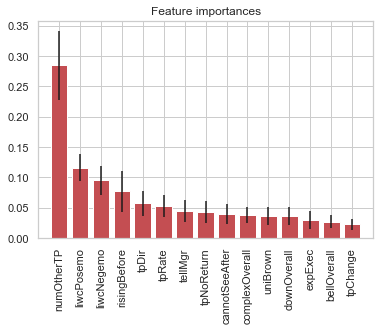

In [212]:
np.random.seed(3851)
train_inds, test_inds = next(GroupShuffleSplit(test_size=0.2,
                                               n_splits=2).split(X=dropped.iloc[:,5:],y=dropped.iloc[:,2], groups=dropped['graphid']))
X_train = dropped.iloc[train_inds,5:]
X_test = dropped.iloc[test_inds, 5:]
y_train = dropped.iloc[train_inds,2]
y_test = dropped.iloc[test_inds,2]

classifier_gid = RandomForestClassifier(n_estimators=100)
classifier_gid = classifier_gid.fit(X_train, y_train)

y_pred = classifier_gid.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", cm)

# Accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy score: ", acc)

print("proportion: ", y_test.value_counts()/len(y_test))

importance_plot(classifier_gid,X_test,file="Figures/rf_graphid.png")

## Scatterplot of most important feature vs 2nd most important

Need to discuss how to better show plots. First one is basic scatter plot, second is treating numTP as a categorical variable, however liwcPosemo may as well be one too since these are repeated features for students.

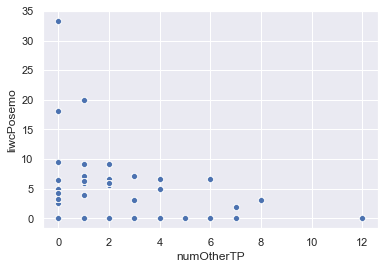

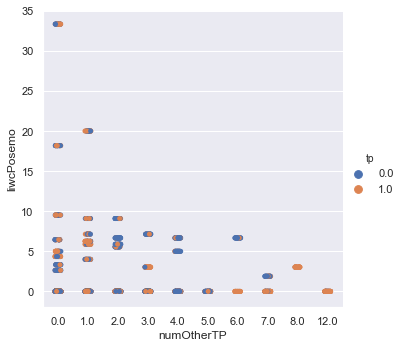

In [124]:
import seaborn as sns; sns.set()
ax = sns.scatterplot(x="numOtherTP", y="liwcPosemo", data=dropped)
#ax.set_ylabel("Diverging")
sns.catplot(x="numOtherTP", y="liwcPosemo", hue="tp", data=dropped)

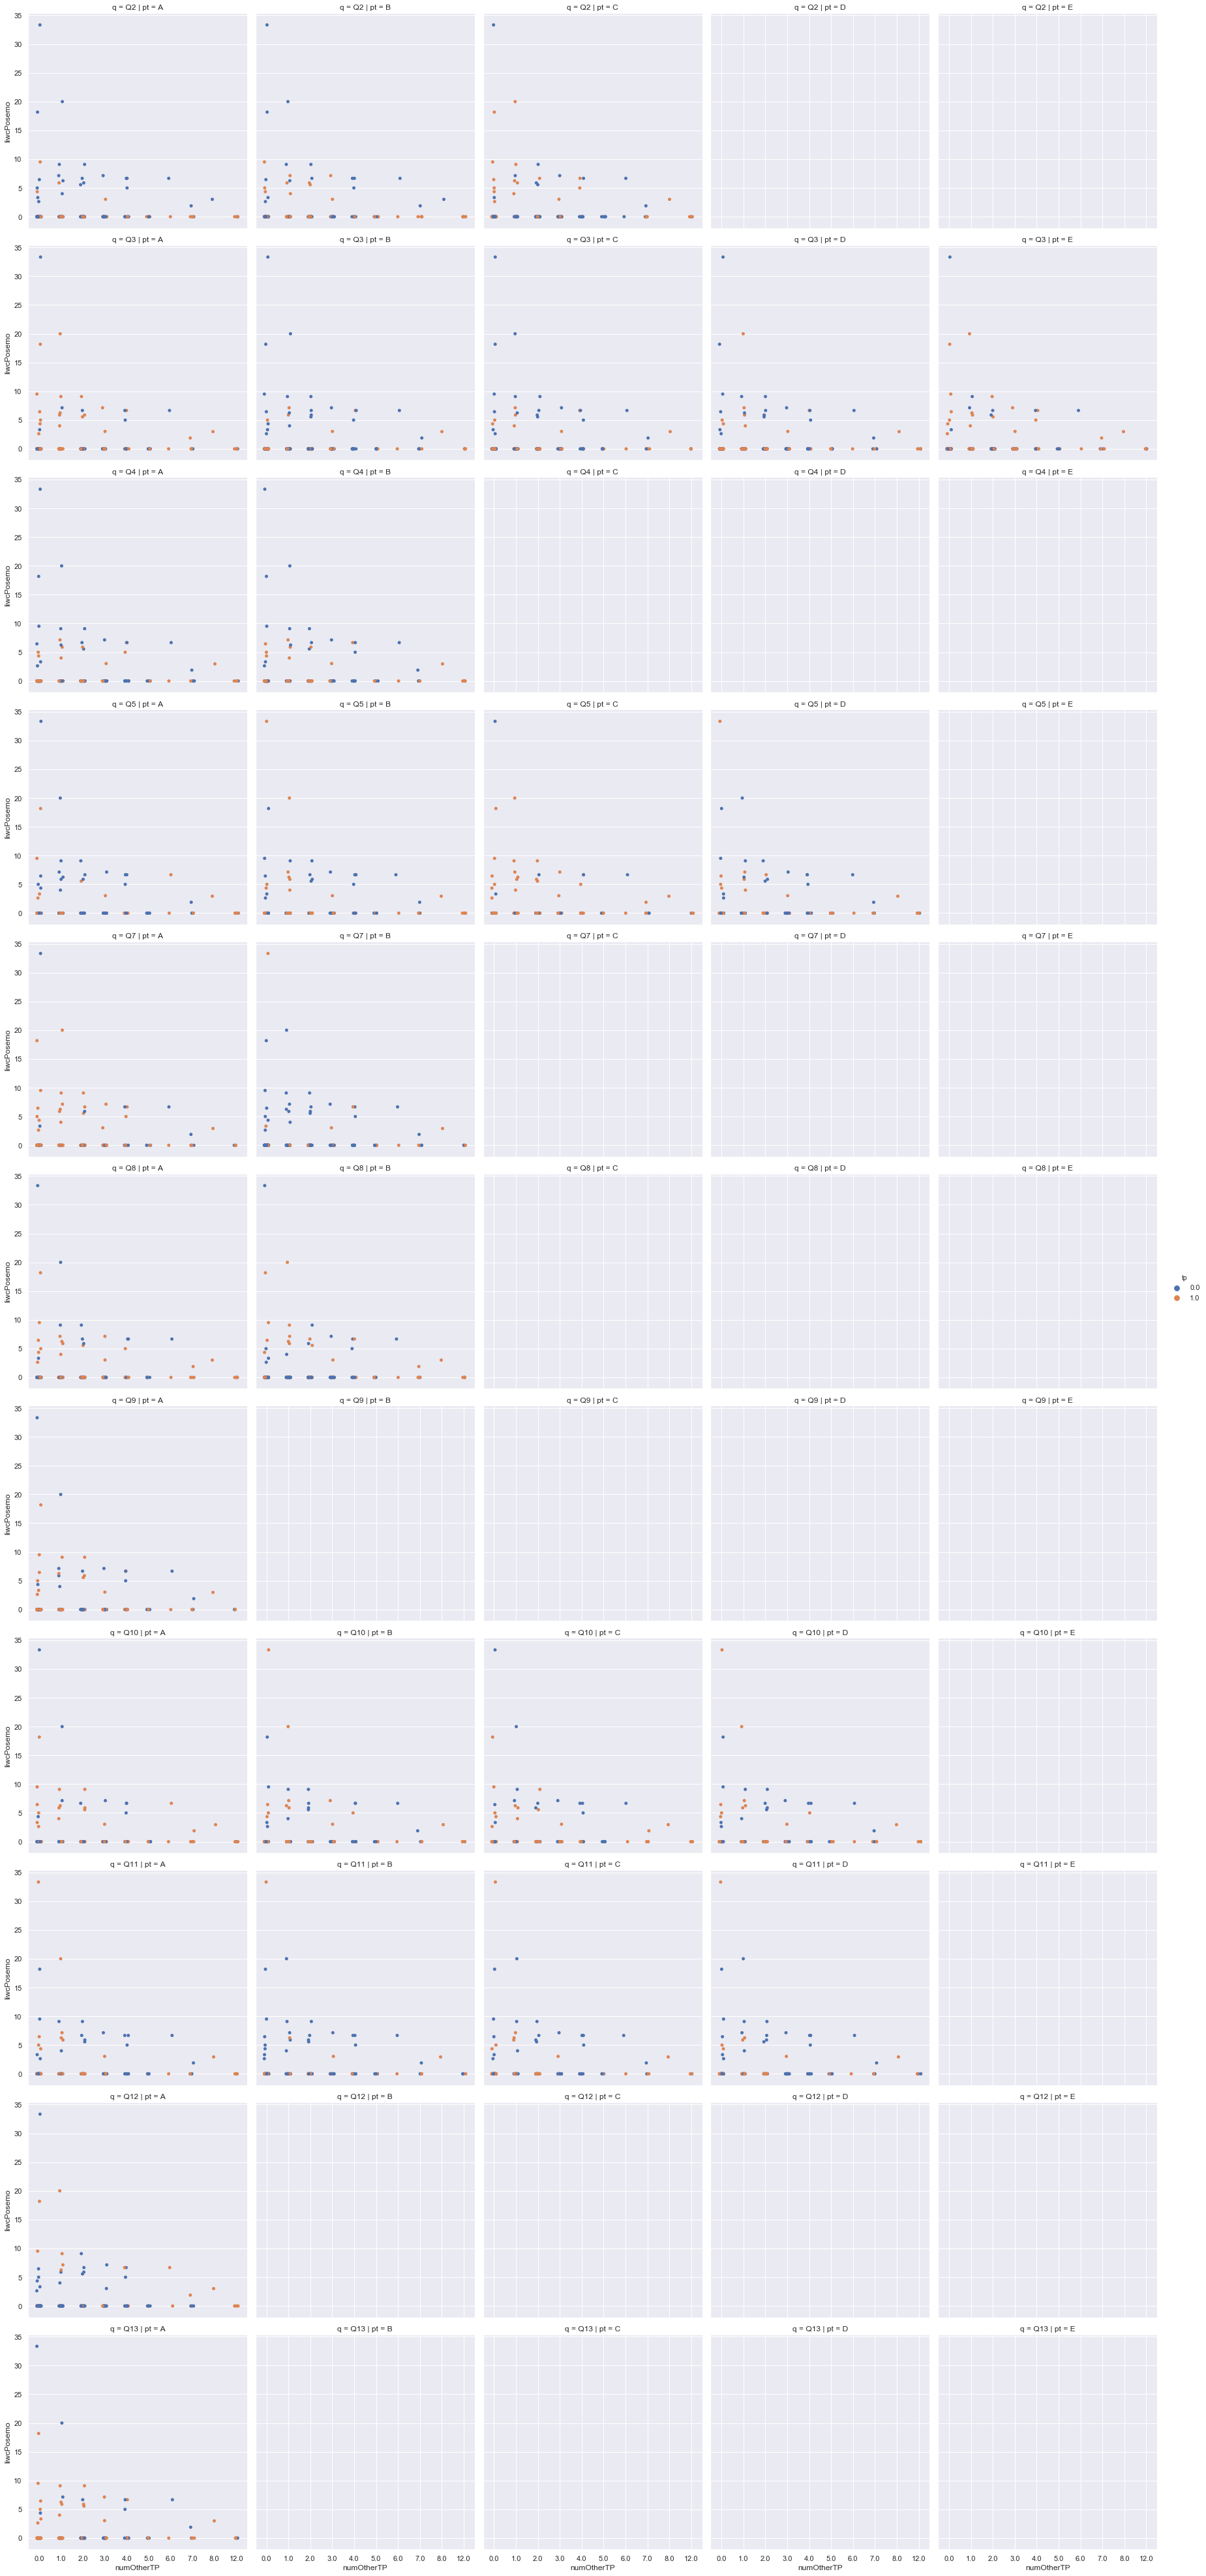

In [131]:
# plot by graph
sns.catplot(y="liwcPosemo", x="numOtherTP", hue="tp",
            col="pt", row="q", data=dropped)

In [ ]:
# feature scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fit our model to training set 
classifier = classifier.fit(X_train, y_train)

# Predict test set results
y_pred = classifier.predict(X_test)

In [214]:
# Visualising the Training set results
X1, X2 = np.meshgrid(np.arange(start = X_train.iloc[:, 0].min() - 1, stop = X_train.iloc[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_train.iloc[:, 1].min() - 1, stop = X_train.iloc[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_train[y_train == j, 0], X_train[y_train == j, 1],
                label = j)
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('numOtherTP')
plt.ylabel('liwcPosemo')
plt.legend()
plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 15 and input n_features is 2 